In [1]:
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from ultralytics import YOLO
bridge = CvBridge()

device = "mps"
model = YOLO("../models/yolov8l-seg.pt")

rgb_file = "rgb.txt"
depth_file = "depth.txt"

/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import yaml
from tqdm import tqdm

def read_images_from_file(file_path):
    # Read the file contents
    with open(file_path, 'r') as file:
        data = file.read()

    # Split the data into individual messages
    messages = data.split('---')
    images = []
    for msg_data in tqdm(messages[-2:]):
        msg_data = msg_data.strip()  # Ensure there is data to process
        if msg_data:  # Only proceed if msg_data is not empty
            # Parse the YAML data
            msg_dict = yaml.safe_load(msg_data)
            # Create an Image message from the dictionary
            image_msg = Image()
            image_msg.header.seq = msg_dict['header']['seq']
            image_msg.header.stamp.secs = msg_dict['header']['stamp']['secs']
            image_msg.header.stamp.nsecs = msg_dict['header']['stamp']['nsecs']
            image_msg.header.frame_id = msg_dict['header']['frame_id']
            image_msg.height = msg_dict['height']
            image_msg.width = msg_dict['width']
            image_msg.encoding = msg_dict['encoding']
            image_msg.is_bigendian = msg_dict['is_bigendian']
            image_msg.step = msg_dict['step']
            image_msg.data = bytearray(msg_dict['data'])
            # Convert the Image message to a CV2 image
            image_cv2 = bridge.imgmsg_to_cv2(image_msg, desired_encoding='passthrough')
    
            images.append(image_cv2)
    
    return images
            

In [11]:
rgb_images = read_images_from_file(rgb_file)
depth_images = read_images_from_file(depth_file)

100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


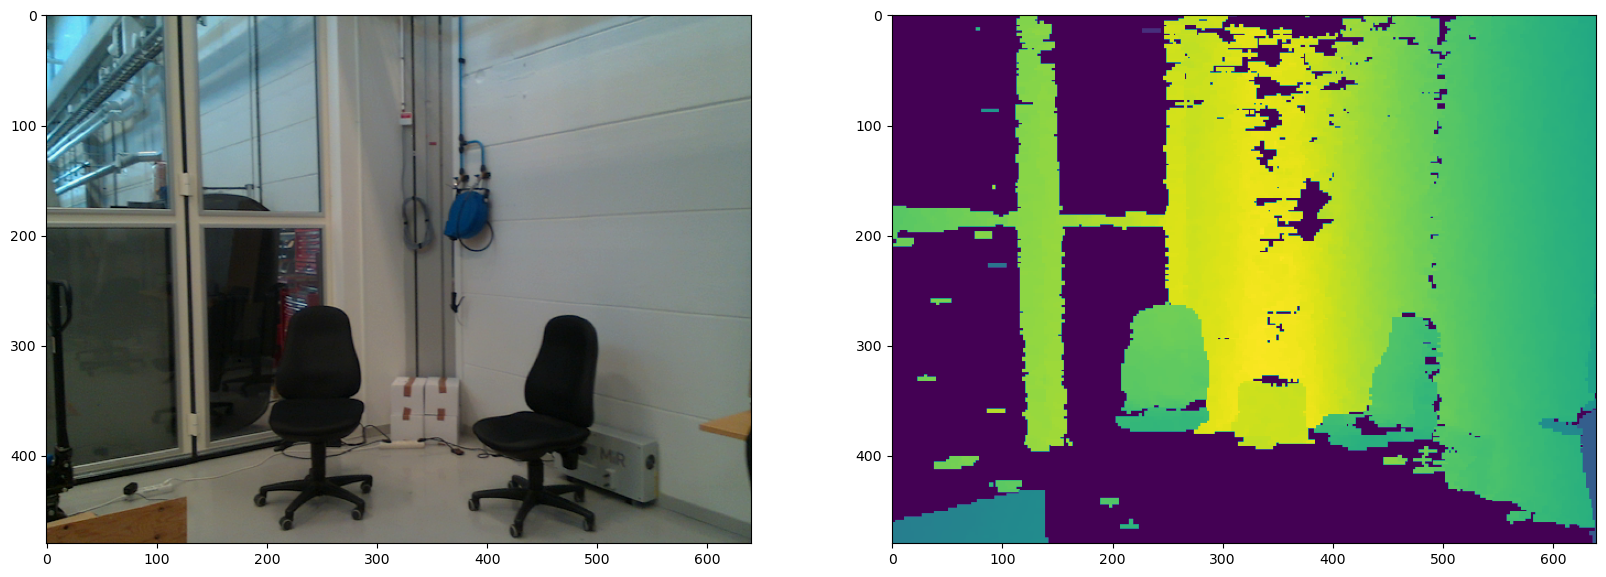

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_images[0])
ax[1].imshow(depth_images[0])
plt.show()

In [80]:
rgb_image, depth_image = rgb_images[0], depth_images[0]
result = model(rgb_image)[0]


0: 480x640 2 chairs, 286.9ms
Speed: 2.0ms preprocess, 286.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


In [81]:
masks = result.masks
classes = result.names
cls = result.boxes.cls

masks.shape, classes, cls

(torch.Size([2, 480, 640]),
 {0: 'person',
  1: 'bicycle',
  2: 'car',
  3: 'motorcycle',
  4: 'airplane',
  5: 'bus',
  6: 'train',
  7: 'truck',
  8: 'boat',
  9: 'traffic light',
  10: 'fire hydrant',
  11: 'stop sign',
  12: 'parking meter',
  13: 'bench',
  14: 'bird',
  15: 'cat',
  16: 'dog',
  17: 'horse',
  18: 'sheep',
  19: 'cow',
  20: 'elephant',
  21: 'bear',
  22: 'zebra',
  23: 'giraffe',
  24: 'backpack',
  25: 'umbrella',
  26: 'handbag',
  27: 'tie',
  28: 'suitcase',
  29: 'frisbee',
  30: 'skis',
  31: 'snowboard',
  32: 'sports ball',
  33: 'kite',
  34: 'baseball bat',
  35: 'baseball glove',
  36: 'skateboard',
  37: 'surfboard',
  38: 'tennis racket',
  39: 'bottle',
  40: 'wine glass',
  41: 'cup',
  42: 'fork',
  43: 'knife',
  44: 'spoon',
  45: 'bowl',
  46: 'banana',
  47: 'apple',
  48: 'sandwich',
  49: 'orange',
  50: 'broccoli',
  51: 'carrot',
  52: 'hot dog',
  53: 'pizza',
  54: 'donut',
  55: 'cake',
  56: 'chair',
  57: 'couch',
  58: 'potted plan

In [159]:
import numpy as np
import cv2

idx = np.argwhere(cls == 56.)[0]#56 = chair
mask = masks[idx[0]]
mask = np.array(mask.data.numpy()[0], dtype=np.uint8)
#mask = cv2.erode(mask, np.ones((10, 10), np.uint8), iterations=1)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

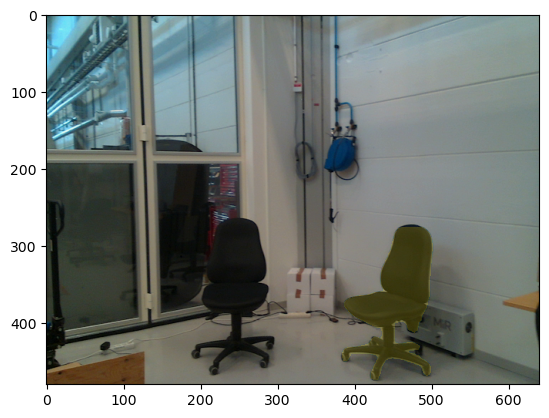

In [160]:
#show mask[i] on image
import matplotlib.pyplot as plt
alpha = np.where(mask == 0, 0, 0.2)
plt.imshow(rgb_image)
plt.imshow(mask, alpha=alpha, cmap='viridis')


In [139]:
import cv2
def compute_pointcloud(depth_image, mask):
    pc = depth_image * mask
    (ys, xs) = np.argwhere(pc).T

    # remove from the pointcloud the points that are too close or too far from the camera
    zs = pc[ys, xs] / 5

    pointcloud = np.array([xs, ys, zs]).T

    return pointcloud

pc = compute_pointcloud(depth_image, mask)
pc.shape

(5682, 3)

In [140]:
depth_image.shape, mask.shape, rgb_image.shape

((480, 640), (480, 640), (480, 640, 3))

In [141]:
np.min(pc, axis=0), np.max(pc, axis=0)

(array([        393,         281,         621]),
 array([        498,         408,       817.2]))

In [142]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)

In [158]:
o3d.visualization.draw_geometries([pcd, axis])